# Pytorch开发深度学习模型一般步骤

## 1.定义DataSet
- 理解数据原始形式
- 理解数据编码方式
- 理解如何进行数据I/O

## 2.定义模型
- 定义各个子模块
- 将子模块合并成最终的模型

## 3.完成Train Pipeline/Valid Pipeline
- Pytorch一般的Train Pipeline/Valid Pipeline书写



In [202]:
import torch
from torch.utils.data import Dataset
import torch.utils.data as D
from torch import nn
import pandas as pd
import numpy as np
import copy
import os
from sklearn.metrics import roc_auc_score,log_loss
from tqdm.notebook import tqdm
import random
from collections import defaultdict
import math

In [142]:
#参数配置

config = {
    "behaviour_path":'ml-1m.inter',
    "user_path":'ml-1m.user',
    "item_path":'ml-1m.item',
    "debug_mode" : False,
    "epoch" : 50,
    "batch" : 10240,
    "lr" : 0.0001,
    "device" : -1,
}

In [235]:
df = pd.read_csv(config['behaviour_path'],sep='\t')

In [237]:
df

,user_id:token,item_id:token,rating:float,timestamp:float
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [238]:
df = df.rename(columns={k:k.split(':')[0] for k in df.columns})

In [239]:
df

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [240]:
# 对DataFrame里面某一列的操作方法

# map : 使用map方法，需要传入一个k:v对，这里的k需要时改列的所有值，v是映射后的值
# apply : 使用apply方法需要传入一个函数，这个函数里面需要定义对一个值的操作逻辑
df['user_count'] = df['user_id'].map(df['user_id'].value_counts())

In [247]:
df = df[df['user_count']>20].reset_index(drop=True)
df.shape

(998489, 5)

In [248]:
pos_df = df[df['rating']>3].reset_index(drop=True)
pos_df.shape

(574238, 5)

In [249]:
pos_df = pos_df.sort_values(by=['user_id','timestamp'],ascending=True)

In [251]:
pos_dict = pos_df.groupby('user_id')['item_id'].apply(list).to_dict()

In [143]:
# 负采样
ratio = 3
# 构造样本
train_user_list = []
train_item_list = []
train_label_list = []

test_user_list = []
test_item_list = []
test_label_list = []
if config['debug_mode']:
    user_list = pos_df['user_id'].unique()[:1000]
else:
    user_list = pos_df['user_id'].unique()
    
item_list = pos_df['item_id'].unique()
item_num = pos_df['item_id'].nunique()

for user in tqdm(user_list):
    # 训练集正样本
    for i in range(len(pos_dict[user])-1):
        train_user_list.append(user)
        train_item_list.append(pos_dict[user][i])
        train_label_list.append(1)
        
    # 测试集正样本
    test_user_list.append(user)
    test_item_list.append(pos_dict[user][-1])
    test_label_list.append(1)
    
    # 训练集：每个用户负样本数
    user_count = len(pos_dict[user])-1 # 训练集 用户行为序列长度
    neg_sample_per_user = user_count * ratio

    for i in range(neg_sample_per_user):
        train_user_list.append(user)
        temp_item_index = random.randint(0, item_num - 1)
        # 为了防止 负采样选出来的Item 在用户的正向历史行为序列(pos_dict)当中
        while item_list[temp_item_index] in pos_dict[user]:
            temp_item_index = random.randint(0, item_num - 1)
        train_item_list.append(item_list[temp_item_index])
        train_label_list.append(0)
    
    # 测试集合：每个用户负样本数为 100(论文设定)
    for i in range(100):
        test_user_list.append(user)
        temp_item_index = random.randint(0, item_num - 1)
        # 为了防止 负采样选出来的Item 在用户的正向历史行为序列(pos_dict)当中
        while item_list[temp_item_index] in pos_dict[user]:
            temp_item_index = random.randint(0, item_num - 1)
        test_item_list.append(item_list[temp_item_index])
        test_label_list.append(0)
        
train_df = pd.DataFrame()
train_df['user_id'] = train_user_list
train_df['item_id'] = train_item_list
train_df['label'] = train_label_list

test_df = pd.DataFrame()
test_df['user_id'] = test_user_list
test_df['item_id'] = test_item_list
test_df['label'] = test_label_list

  0%|          | 0/5952 [00:00<?, ?it/s]

In [144]:
train_df.shape,test_df.shape

((2273144, 3), (601152, 3))

## 1.定义DataSet
- 理解数据原始形式
- 理解数据编码方式
- 理解如何进行数据I/O




In [164]:
#Dataset构造
class BaseDataset(Dataset):
    def __init__(self,config,df,enc_dict=None):
        self.config = config
        self.df = df
        self.enc_dict = enc_dict
        self.dense_cols = []
        self.sparse_cols = ['user_id','item_id']
        self.feature_name = self.dense_cols+self.sparse_cols+['label']

        #数据编码
        if self.enc_dict == None:
            self.get_enc_dict()
        self.enc_data()

    def get_enc_dict(self):
        #计算enc_dict
        self.enc_dict = dict(zip( list(self.dense_cols+self.sparse_cols),[dict() for _ in range(len(self.dense_cols+self.sparse_cols))]))
        for f in self.sparse_cols:
            self.df[f] = self.df[f].astype('str')
            map_dict = dict(zip(self.df[f].unique(), range(1,self.df[f].nunique()+1)))
            self.enc_dict[f] = map_dict
            self.enc_dict[f]['vocab_size'] = self.df[f].nunique()+1
            '''
            eg:C17 特征的map_dict
            {'e5ba7672': 1,
             '07c540c4': 2,
             '8efede7f': 3,
             '1e88c74f': 4,
             '776ce399': 5,
             'd4bb7bd8': 6,
             '3486227d': 7,
             '27c07bd6': 8,
             '2005abd1': 9,
             'vocab_size': 10}
            '''

        for f in self.dense_cols:
            self.enc_dict[f]['min'] = self.df[f].min()
            self.enc_dict[f]['max'] = self.df[f].max()
            '''
            eg:I6 特征
            {'min': 0.0, 'max': 4638.0}
            '''
        return self.enc_dict

    def enc_dense_data(self,col):
        return (self.df[col] - self.enc_dict[col]['min']) / (self.enc_dict[col]['max'] - self.enc_dict[col]['min'])

    def enc_sparse_data(self,col):
        self.df[col] = self.df[col].astype('str')
        return self.df[col].apply(lambda x : self.enc_dict[col].get(x,0))

    def enc_data(self):
        #使用enc_dict对数据进行编码
        self.enc_data = defaultdict(np.array)

        for col in self.dense_cols:
            self.enc_data[col] = torch.Tensor(np.array(self.enc_dense_data(col)))
        for col in self.sparse_cols:
            self.enc_data[col] = torch.Tensor(np.array(self.enc_sparse_data(col))).long()

    def __getitem__(self, index):
        data = defaultdict(np.array)
        for col in self.dense_cols:
            data[col] = self.enc_data[col][index]
        for col in self.sparse_cols:
            data[col] = self.enc_data[col][index]
        if 'label' in self.df.columns :
            data['label'] = torch.Tensor([self.df['label'].iloc[index]]).squeeze(-1)
        return data

    def __len__(self):
        return len(self.df)

In [165]:
train_dataset = BaseDataset(config,train_df)
enc_dict = train_dataset.get_enc_dict()

test_dataset = BaseDataset(config,test_df,enc_dict=enc_dict)

In [255]:
test_dataset.__getitem__(0)

defaultdict(<function numpy.array>,
            {'user_id': tensor(5951),
             'item_id': tensor(1709),
             'label': tensor(0.)})

## 2.定义模型
- 定义各个子模块
- 将子模块合并成最终的模型

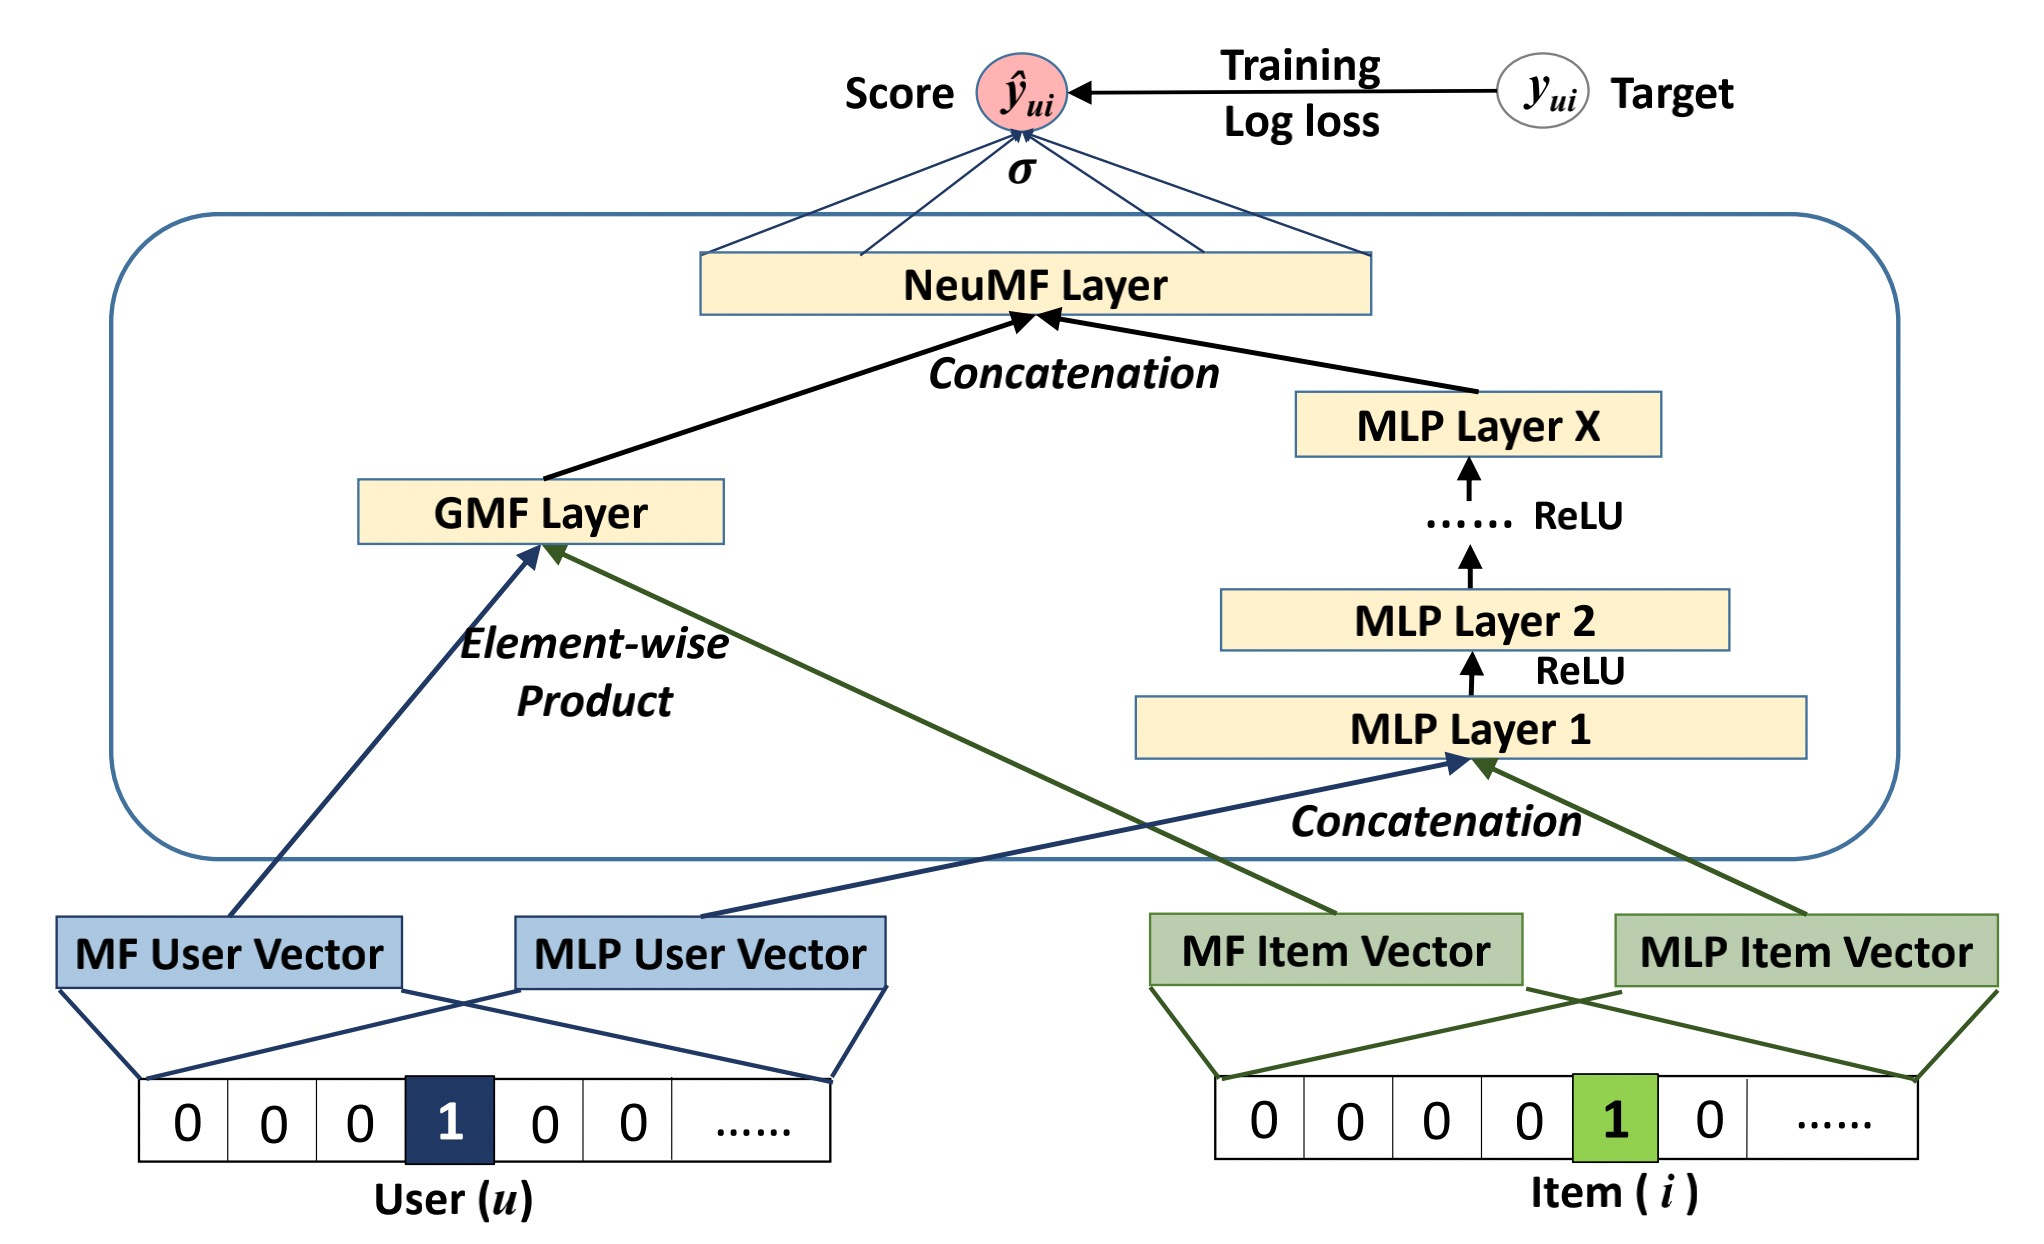

In [148]:
#GMF层
class GMF(nn.Module):
    def __init__(self,embedding_dim):
        super(GMF, self).__init__()
        self.embedding_dim = embedding_dim
        self.fc = nn.Linear(self.embedding_dim,self.embedding_dim)
    
    def forward(self, user_emb, item_emb):
        out = self.fc(user_emb*item_emb).sigmoid()
        return out
    
#MLP
class MLP_Layer(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim=None,
                 hidden_units=[],
                 hidden_activations="ReLU",
                 final_activation=None,
                 dropout_rates=0,
                 batch_norm=False,
                 use_bias=True):
        super(MLP_Layer, self).__init__()
        dense_layers = []
        if not isinstance(dropout_rates, list):
            dropout_rates = [dropout_rates] * len(hidden_units)
        if not isinstance(hidden_activations, list):
            hidden_activations = [hidden_activations] * len(hidden_units)
        hidden_activations = [set_activation(x) for x in hidden_activations]
        hidden_units = [input_dim] + hidden_units
        for idx in range(len(hidden_units) - 1):
            dense_layers.append(nn.Linear(hidden_units[idx], hidden_units[idx + 1], bias=use_bias))
            if batch_norm:
                dense_layers.append(nn.BatchNorm1d(hidden_units[idx + 1]))
            if hidden_activations[idx]:
                dense_layers.append(hidden_activations[idx])
            if dropout_rates[idx] > 0:
                dense_layers.append(nn.Dropout(p=dropout_rates[idx]))
        if output_dim is not None:
            dense_layers.append(nn.Linear(hidden_units[-1], output_dim, bias=use_bias))
        if final_activation is not None:
            dense_layers.append(set_activation(final_activation))
        self.dnn = nn.Sequential(*dense_layers)  # * used to unpack list

    def forward(self, inputs):
        return self.dnn(inputs)

def set_device(gpu=-1):
    if gpu >= 0 and torch.cuda.is_available():
        os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)
        device = torch.device(f"cuda:{gpu}")
    else:
        device = torch.device("cpu")
    return device
    
def set_activation(activation):
    if isinstance(activation, str):
        if activation.lower() == "relu":
            return nn.ReLU()
        elif activation.lower() == "sigmoid":
            return nn.Sigmoid()
        elif activation.lower() == "tanh":
            return nn.Tanh()
        else:
            return getattr(nn, activation)()
    else:
        return activation
    
def get_dnn_input_dim(enc_dict,embedding_dim):
    num_sparse = 0
    num_dense = 0
    for col in enc_dict.keys():
        if 'min' in enc_dict[col].keys():
            num_dense+=1
        elif 'vocab_size' in enc_dict[col].keys():
            num_sparse+=1
    return num_sparse*embedding_dim+num_dense

def get_linear_input(enc_dict,data):
    res_data = []
    for col in enc_dict.keys():
        if 'min' in enc_dict[col].keys():
            res_data.append(data[col])
    res_data = torch.stack(res_data,axis=1)
    return res_data

In [149]:
# NCF 模型
class NCF(nn.Module):
    def __init__(self,
                 embedding_dim1=16, # GMF 对应的Embedding层
                 embedding_dim2=32, # MLP 对应的Embedding层
                 hidden_units=[64, 32, 16],
                 loss_fun = 'torch.nn.BCELoss()',
                 enc_dict=None):
        super(NCF, self).__init__()

        self.embedding_dim1 = embedding_dim1 # GMF Emb
        self.embedding_dim2 = embedding_dim2 # MLP Emb
        self.hidden_units = hidden_units
        self.loss_fun = eval(loss_fun)
        self.enc_dict = enc_dict

        # GMF
        self.user_emb_layer1 = nn.Embedding(self.enc_dict['user_id']['vocab_size'],
                                           self.embedding_dim1)
        self.item_emb_layer1 = nn.Embedding(self.enc_dict['item_id']['vocab_size'],
                                           self.embedding_dim1)
        # MLP
        self.user_emb_layer2 = nn.Embedding(self.enc_dict['user_id']['vocab_size'],
                                           self.embedding_dim2)
        self.item_emb_layer2 = nn.Embedding(self.enc_dict['item_id']['vocab_size'],
                                           self.embedding_dim2)
        
        self.gmf = GMF(self.embedding_dim1)

        self.mlp = MLP_Layer(input_dim=self.embedding_dim2*2, hidden_units=self.hidden_units,
                                 hidden_activations='relu', dropout_rates=0)
        
        # GMF:[batch,Emb1] MLP:[batch,hidden_units[-1]]-> FC的输入维度:self.embedding_dim1 + self.hidden_units[-1]
        self.fc = nn.Linear(self.embedding_dim1 + self.hidden_units[-1],1)

    def forward(self, data):
        # GMF
        user_emb1 = self.user_emb_layer1(data['user_id'])
        item_emb1 = self.item_emb_layer1(data['item_id'])
        
        # MLP
        user_emb2 = self.user_emb_layer2(data['user_id'])
        item_emb2 = self.item_emb_layer2(data['item_id'])
        
        # GMF
        gmf_out = self.gmf(user_emb1, item_emb1)
        # MLP
        mlp_input = torch.cat([user_emb2,item_emb2],axis=-1)
        mlp_out = self.mlp(mlp_input)
        
        #输出
        final_input = torch.cat([gmf_out,mlp_out],axis=-1)
        y_pred = self.fc(final_input).sigmoid()
        
        loss = self.loss_fun(y_pred.squeeze(-1),data['label'])
        output_dict = {'pred':y_pred,'loss':loss}
        return output_dict

## 3.完成Train Pipeline/Valid Pipeline
- Pytorch一般的Train Pipeline/Valid Pipeline书写

In [150]:
#训练模型，验证模型
def train_model(model, train_loader, optimizer, device, metric_list=['roc_auc_score','log_loss']):
    model.train()
    pred_list = []
    label_list = []
    pbar = tqdm(train_loader)
    for data in pbar:

        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']
        loss = output['loss']

        loss.backward()
        optimizer.step()
        model.zero_grad()

        pred_list.extend(pred.squeeze(-1).cpu().detach().numpy())
        label_list.extend(data['label'].squeeze(-1).cpu().detach().numpy())
        pbar.set_description("Loss {}".format(loss))

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

def valid_model(model, valid_loader, device, metric_list=['roc_auc_score','log_loss']):
    model.eval()
    pred_list = []
    label_list = []

    for data in (valid_loader):

        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']

        pred_list.extend(pred.squeeze(-1).cpu().detach().numpy())
        label_list.extend(data['label'].squeeze(-1).cpu().detach().numpy())

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

def test_model(model, test_loader, device, metric_list=['roc_auc_score','log_loss']):
    model.eval()
    pred_list = []
    label_list = []

    for data in (test_loader):

        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']

        pred_list.extend(pred.squeeze().cpu().detach().numpy())
        label_list.extend(data['label'].squeeze().cpu().detach().numpy())

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

def get_test_predict(model, test_loader, device):
    model.eval()
    pred_list = []

    for data in tqdm(test_loader):

        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']

        pred_list.extend(pred.squeeze().cpu().detach().numpy())

    return pred_list

In [177]:
#dataloader
#num_workers:多线程取batch数据，⚠️在win的notebook下，num_workers只能取0，不然会有意外的bug
train_loader = D.DataLoader(train_dataset,batch_size=config['batch'],shuffle=True,num_workers=8)
test_loader = D.DataLoader(test_dataset,batch_size=config['batch'],shuffle=False,num_workers=0)

In [152]:
model = NCF(enc_dict=enc_dict)

In [173]:
device = set_device(config['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
model = model.to(device)
#模型训练流程
for i in range(config['epoch']):
    #模型训练
    train_metirc = train_model(model,train_loader,optimizer=optimizer,device=device)

    print(f"Epoch {i+1} Train Metric:")
    print(train_metirc)
#测试模型
test_metric = test_model(model,test_loader,device)
print('Test Metric:')
print(test_metric)

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1 Train Metric:
{'roc_auc_score': 0.8727404904912642, 'log_loss': 0.3732661280815489}


  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2 Train Metric:
{'roc_auc_score': 0.8728716445803372, 'log_loss': 0.37308435679032415}


  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3 Train Metric:
{'roc_auc_score': 0.8729849658498963, 'log_loss': 0.3729284413993329}


  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4 Train Metric:
{'roc_auc_score': 0.8731195730726738, 'log_loss': 0.37275001168228467}


  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5 Train Metric:
{'roc_auc_score': 0.8732305515412997, 'log_loss': 0.37259658432346393}
Test Metric:
{'roc_auc_score': 0.5000428427419354, 'log_loss': 0.22978873300258723}


In [178]:
y_pre = get_test_predict(model,test_loader,device)
test_df['y_pre'] = y_pre

  0%|          | 0/59 [00:00<?, ?it/s]

In [179]:
test_df['ranking'] = test_df.groupby(['user_id'])['y_pre'].rank(method='first', ascending=False)

In [181]:
test_df = test_df.sort_values(by=['user_id','ranking'],ascending=True)
test_df

,user_id,item_id,label,y_pre,ranking
69,1,593,0,0.921699,1.0
33,1,1240,0,0.888522,2.0
24,1,923,0,0.750764,3.0
42,1,2700,0,0.701666,4.0
96,1,2336,0,0.655084,5.0
...,...,...,...,...,...
99417,999,997,0,0.002155,97.0
99394,999,1372,0,0.001735,98.0
99460,999,3594,0,0.001625,99.0
99458,999,3889,0,0.001257,100.0


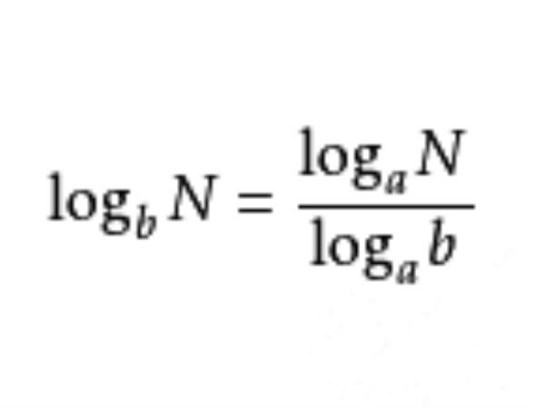

In [259]:
def hitrate(test_df,k=20):
    user_num = test_df['user_id'].nunique()
    test_gd_df = test_df[test_df['ranking']<=k].reset_index(drop=True)
    return test_gd_df['label'].sum() / user_num

def ndcg(test_df,k=20):
    '''
    idcg@k 一定为1
    dcg@k 1/log_2(ranking+1) -> log(2)/log(ranking+1)
    '''
    user_num = test_df['user_id'].nunique()
    test_gd_df = test_df[test_df['ranking']<=k].reset_index(drop=True)
    
    test_gd_df = test_gd_df[test_gd_df['label']==1].reset_index(drop=True)
    test_gd_df['ndcg'] = math.log(2) / np.log(test_gd_df['ranking']+1)
    return test_gd_df['ndcg'].sum() / user_num

In [256]:
hitrate(test_df,k=10)

0.4645497311827957

In [258]:
hitrate(test_df,k=30)

0.7710013440860215

In [261]:
ndcg(test_df,k=50)

0.35056269051441225

In [234]:
np.log(2)

0.6931471805599453